In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

/home/amoshyc/miniconda3/envs/nthu-dl/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class LinearRegressor:
    '''Closed-form solution'''
    def __init__(self):
        self.W = None
    
    def fit(self, xs, ys):
        self.W = np.linalg.pinv(xs.T @ xs) @ xs.T @ ys
    
    def predict(self, xs):
        return xs @ self.W

In [3]:
class LinearSGD:
    def __init__(self, lr=1e-1, batch_size=32, n_epoch=500, pbar=True):
        self.lr = lr
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.pbar = pbar
        self.W = None
        self.b = None
    
    def fit(self, xs, ys):
        N, F = xs.shape
        n_step = N // self.batch_size
        self.W = np.random.normal(loc=0.0, scale=0.01, size=(F, 1))
        self.b = np.random.normal(loc=0.0, scale=0.01, size=(1,))
        
        epochs = range(self.n_epoch)
        if self.pbar:
            epochs = tqdm(epochs)
        
        for ep in epochs:
            indices = np.random.permutation(n_step * self.batch_size)
            avg_loss = 0.0
            for it in range(n_step):
                s = it * self.batch_size
                t = min(s + self.batch_size, N)
                x_batch = xs[indices[s:t]]
                y_batch = ys[indices[s:t]]
                loss = self.partial_fit(x_batch, y_batch)
                avg_loss = ((avg_loss * it) + loss) / (it + 1)
            yield avg_loss
            
    def partial_fit(self, x_batch, y_batch):
        B, F = x_batch.shape
        y_batch = np.expand_dims(y_batch, axis=-1) # [B, 1]
        p_batch = self.forward(x_batch) # [B, 1]
        l_batch = 0.5 * np.sum((y_batch - p_batch)**2, axis=1) # [B, 1]
        loss = l_batch.mean() # float
        
        dL = np.ones((B, 1)) / B # [B, 1]
        dP = dL * (p_batch - y_batch) # [B, 1]
        dW = x_batch.T @ dP # [F, 1]
        dB = dP # [B, 1]
        db = dB.sum(axis=0) # [1]
        
        self.W = self.W - self.lr * dW
        self.b = self.b - self.lr * db
        return float(loss)
    
    def forward(self, x_batch):
        return x_batch @ self.W + self.b
    
    def predict(self, xs):
        return self.forward(xs).squeeze(axis=1)

    
xs = np.random.rand(100, 2)
ys = xs[:, 0] * 3 + xs[:, 1] * 4
reg = LinearSGD()
losses = list(reg.fit(xs, ys))
print(reg.W)


[[2.99883964]
 [3.99848222]]


In [4]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values

In [5]:
xt, xv, yt, yv = train_test_split(X, y, test_size=0.3, random_state=50)

stdx = StandardScaler()
stdx.fit(xt)
xt_std = stdx.transform(xt)
xv_std = stdx.transform(xv)

print(xt_std.shape, yt.shape)
print(xv_std.shape, yv.shape)

(1491, 11) (1491,)
(639, 11) (639,)


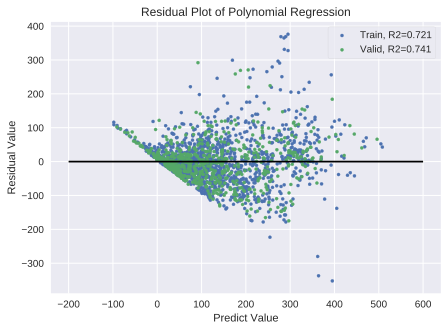

In [6]:
poly = PolynomialFeatures(degree=3)
poly.fit(xt_std)
xt_poly = poly.transform(xt_std)
xv_poly = poly.transform(xv_std)

std = StandardScaler()
std.fit(xt_poly)
xt_poly_std = std.transform(xt_poly)
xv_poly_std = std.transform(xv_poly)

reg = LinearSGD(lr=1e-4, batch_size=4, n_epoch=200)
losses = list(reg.fit(xt_poly_std, yt))
pt = reg.predict(xt_poly_std)
pv = reg.predict(xv_poly_std)

fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
ax.scatter(pt, yt - pt, s=10, label=f'Train, R2={r2_score(yt, pt):.3f}')
ax.scatter(pv, yv - pv, s=10, label=f'Valid, R2={r2_score(yv, pv):.3f}')
ax.hlines(y=0, xmin=-200, xmax=600)
ax.legend(frameon=True)
ax.set_title('Residual Plot of Polynomial Regression')
ax.set_xlabel('Predict Value')
ax.set_ylabel('Residual Value')
plt.show()

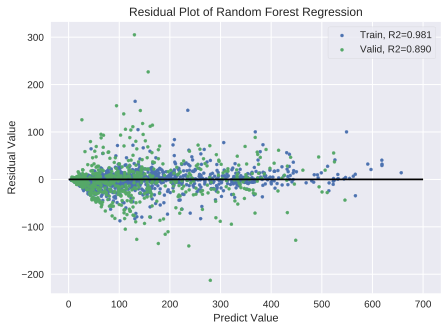

In [7]:
reg = RandomForestRegressor(criterion='mse')
reg.fit(xt_std, yt)
pt = reg.predict(xt_std)
pv = reg.predict(xv_std)

fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
ax.scatter(pt, yt - pt, s=10, label=f'Train, R2={r2_score(yt, pt):.3f}')
ax.scatter(pv, yv - pv, s=10, label=f'Valid, R2={r2_score(yv, pv):.3f}')
ax.hlines(y=0, xmin=0, xmax=700)
ax.legend(frameon=True)
ax.set_title('Residual Plot of Random Forest Regression')
ax.set_xlabel('Predict Value')
ax.set_ylabel('Residual Value')
plt.show()